## Jupyter Crash Course

1. Select cells by clicking on them.
2. Navigate through with `up` and `down` keys (or `k` and `j` for you vimmers).
3. Press Enter to edit a cell.
4. Press Shift-Enter to execute it.
5. Create new cells above or below the current one with `a` or `b`.
6. Copy, cut and paste them with `c`, `x` and `v`.
7. Press `m` to turn a cell into a markdown cell.
8. See the `Help` in the toolbar for more.

## Importing necessary libraries

As a first step we import the libraries [numpy](http://www.numpy.org/) for data analysis and [matplotlib](https://matplotlib.org/) for visualization.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

Fundamentally, we only need to import one module from `pyiron`: the `Project` class

In [2]:
from pyiron import Project

The Project object introduced below is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus, by code completion *Tab* the respective commands can be found easily.

We now create a pyiron Project named 'first_steps'.

## **Working with atomistic structures**

### **Creation of a project instance**

In [3]:
pr = Project("tutorial")

The project name also applies for the directory that is created for the project. All data generated by this `Project` object resides in this directory.

In [4]:
pr.path

'/home/poul/pyiron/dpg_tutorial_2024/02_introduction_to_pyiron/tutorial/'

In [5]:
pr

{'groups': [], 'nodes': []}

The `groups` and `nodes` will be populated later, as we add jobs and sub project to it.

### **Creating atomic structures**

Every atomistic simulation needs an atomic structure. For more details on generating and manipulating structures, please have a look at our [structures example](https://pyiron.readthedocs.io/en/latest/source/notebooks/structures.html). In this section however, we show how to generate and manipulate bulk crystals, surfaces, etc. pyiron's structure class is derived from the popular [`ase` package](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) and any `ase` function to manipulate structures can also be applied here.

Creating a bulk fcc cubic unitcell

In [6]:
Al_unitcell_cubic = pr.create.structure.bulk('Al', cubic=True, a=4.04)
Al_unitcell_cubic

Al: [0. 0. 0.]
Al: [0.   2.02 2.02]
Al: [2.02 0.   2.02]
Al: [2.02 2.02 0.  ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([4.04, 4.04, 4.04])

Creating a super cell.

In [9]:
Al_supercell_3_3_3 = Al_unitcell_cubic.repeat([3, 3, 3])
Al_supercell_3_3_3.plot3d(particle_size=2)

NGLWidget()

Creating a vacancy is easy, just delete an atom.

In [10]:
Al_vacancy = Al_supercell_3_3_3.copy()
del Al_vacancy[0] # Deleting the first atom
print(Al_supercell_3_3_3.get_chemical_formula(), Al_vacancy.get_chemical_formula())
Al_vacancy.plot3d(particle_size=2)

Al108 Al107


NGLWidget()

### **Creating random crystals**

`pyxtal` is a [program](https://pyxtal.readthedocs.io/en/latest/) to generate random structures of a given space group and stoichiometry.
It is useful for crystal structure prediction and also for generating training structures.
We will use it later again, so let's briefly look at how it works.

In [11]:
import structuretoolkit as stk
from pyiron_atomistics import ase_to_pyiron

In [12]:
from pyiron_atomistics.atomistics.structure.structurestorage import StructureStorage

`structuretoolkit` is a library for structure manipulation and analysis also developed by the pyiron team.  For compatibility with a wider range of codes it operates purely on ASE `Atoms` objects, so we need to convert structures explicitely here.  In the next release of `pyiron_atomistics` you will be able to call `pr.create.structure.pyxtal` directly for a more convenient wrapper.

In [13]:
fcc = ase_to_pyiron(stk.build.pyxtal(
    group=225,       # fcc
    species=['Al'],  # list of atoms we want to place
    num_ions=[4],    # how of each of them
))

fcc

Al: [2.33036199 2.33036199 2.33036199]
Al: [2.33036199e+00 9.13407074e-17 9.13407074e-17]
Al: [-5.13528104e-17  2.33036199e+00  9.13407074e-17]
Al: [-5.13528104e-17 -1.08624143e-15  2.33036199e+00]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([[4.660723987355676, 2.853870356412209e-16, 2.853870356412209e-16], [0.0, 4.660723987355676, 2.853870356412209e-16], [0.0, 0.0, 4.660723987355676]])

In [14]:
fcc.plot3d()

NGLWidget()

In [15]:
groups = [1, 194, 225]

In [19]:
store = StructureStorage()
for structure in stk.build.pyxtal(
    group=groups,
    species=['Al'],
    num_ions=[4]
):
    store.add_structure(structure['atoms'])

Spacegroups:   0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
structure = store.get_structure(1)
structure.plot3d()

NGLWidget()

## **Running an atomistic calculation using interatomic potentials (with LAMMPS)**

Once we have an atomic structure, we can set up a simulation "job" of any atomistic simulation that is intergrated within pyiron. In this section, we are going to use the popular [LAMMPS code](https://lammps.sandia.gov/).

In [21]:
# Create a job
job_lammps = pr.create.job.Lammps("lammps_job")

Every atomistic simulation code needs an input atomic structure. We use the Al supercell structure we created earlier

In [22]:
# Assign an atomic structure to the job
job_lammps.structure = pr.create.structure.bulk('Al', cubic=True).repeat(3)

Once the structure is assigned, an appropriate potential should also be chosen. This list of available for the structure containing Al can be found below.  This list originates from the NIST Interatomic Potential Database.

In [23]:
# See available potentials
job_lammps.list_potentials()[20:30]

['2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
 '2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2',
 '2010--Lee-E--Fe-Al--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-1--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-2--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-3--LAMMPS--ipr1',
 '2010--Winey-J-M--Al--LAMMPS--ipr1',
 '2011--Apostol-F--Al-Cu--LAMMPS--ipr1',
 '2011--Ko-W-S--Al-H--LAMMPS--ipr1']

In [24]:
# Choose one of these potentials
job_lammps.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"

At this stage, the computational parameters for the simulation needs to be specified. pyiron parses generic computational parameters into code specific parameters allowing for an easy transition between simulation codes

In [25]:
# specify calculation details: in this case: MD at 800 K in the NPT ensemble (pressure=0) for 10000 steps
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)

We can now see how pyiron sets-up the corresponding LAMMPS input

In [26]:
job_lammps.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all npt temp 800.0 800.0 0.1 iso 0.0 0.0 1.0,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


Once the `run()` commmand is called, pyiron creates necessary input files, calls the simulation code, and finally parses and stores the output.

In [27]:
job_lammps.run()

The job lammps_job was saved and received the ID: 2271


When printing the project, the saved job will also appear under `nodes` now.

In [28]:
pr

{'groups': [], 'nodes': ['lammps_job']}

You can get a quick overview with the `job_table` method.

In [29]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,2271,finished,Al108,lammps_job,/lammps_job,None,/home/poul/pyiron/dpg_tutorial_2024/02_introduction_to_pyiron/tutorial/,2024-03-16 01:46:20.486344,2024-03-16 01:46:23.348630,2.0,pyiron@cmleo38#1,Lammps,0.1,None,None


Once it is finished we can access the parsed output.

In [30]:
job_lammps['output']

{'groups': ['generic'], 'nodes': []}

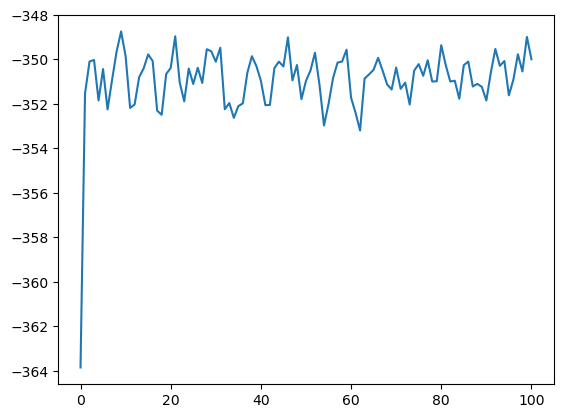

In [31]:
plt.plot(job_lammps['output/generic/energy_pot'])

## **Collecting structures and energies for training**

To train a machine learning potential one usually starts with a set of structures, then run static DFT on each of them.  We will simulate this here, by running `lammps` with an existing potential to save some time.

Let's start by adding structures to our container.

In [32]:
store = StructureStorage()

A usual approach is to start with some prototypical structures and strain and shake them.  We can use the fcc Al we created earlier.

In [33]:
fcc

Al: [2.33036199 2.33036199 2.33036199]
Al: [2.33036199e+00 9.13407074e-17 9.13407074e-17]
Al: [-5.13528104e-17  2.33036199e+00  9.13407074e-17]
Al: [-5.13528104e-17 -1.08624143e-15  2.33036199e+00]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([[4.660723987355676, 2.853870356412209e-16, 2.853870356412209e-16], [0.0, 4.660723987355676, 2.853870356412209e-16], [0.0, 0.0, 4.660723987355676]])

In [34]:
strains = np.linspace(-0.05, 0.05, 5)
strains

array([-0.05 , -0.025,  0.   ,  0.025,  0.05 ])

In [35]:
for eps in strains:
    store.add_structure(
        structure=fcc.apply_strain(eps, return_box=True),
        identifier=f'fcc_{eps}'
    )

In [36]:
fcc.rattle?

Signature: fcc.rattle(stdev=0.001, seed=None, rng=None)
Docstring:
Randomly displace atoms.

This method adds random displacements to the atomic positions,
taking a possible constraint into account.  The random numbers are
drawn from a normal distribution of standard deviation stdev.

For a parallel calculation, it is important to use the same
seed on all processors!  
File:      ~/micromamba/envs/dpg24/lib/python3.11/site-packages/ase/atoms.py
Type:      method

In [51]:
for eps in strains:
    structure = fcc.apply_strain(eps, return_box=True)
    structure.rattle(0.05)
    print('Strain', eps, 'Volume', structure.get_volume(per_atom=True))
    store.add_structure(
        structure=structure,
        identifier=f'fcc_{eps}_rattle'
    )

Strain -0.05 Volume 21.700561812935014
Strain -0.025 Volume 23.459243807069036
Strain 0.0 Volume 25.310467196891707
Strain 0.02500000000000001 Volume 27.25660483870269
Strain 0.05 Volume 29.300029588801753


We usually also use random crystals generated by sampling random space groups.  One would use more spacegroups and differently sized unit cells, but we'll keep it simple here.  Details can be found in this paper.

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.107.104103

In [38]:
for i, structure in enumerate(stk.build.pyxtal(
    group=groups,
    species=['Al'],
    num_ions=[4],
    tm='metallic'
)):
    store.add_structure(
        structure=structure['atoms'],
        identifier=f'random_{i}'
    )

Spacegroups:   0%|          | 0/3 [00:00<?, ?it/s]

Now we can run our "expensive DFT".

In [39]:
store.number_of_structures

13

In [40]:
for i, structure in enumerate(store.iter_structures()):
    # pyiron has some opinions of what is a proper "job name" for technical reasons, but
    # you can always use this function to translate your favorite one into a "proper" one
    name = pr.create.job_name(store['identifier', i])
    job = pr.create.job.Lammps(name)
    job.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
    job.structure = structure
    job.calc_static()
    job.run()

The job fcc_m0d05 was saved and received the ID: 2272
The job fcc_m0d025 was saved and received the ID: 2273
The job fcc_0d0 was saved and received the ID: 2274
The job fcc_0d02500000000000001 was saved and received the ID: 2275
The job fcc_0d05 was saved and received the ID: 2276
The job fcc_m0d05_rattle was saved and received the ID: 2277
The job fcc_m0d025_rattle was saved and received the ID: 2278
The job fcc_0d0_rattle was saved and received the ID: 2279
The job fcc_0d02500000000000001_rattle was saved and received the ID: 2280
The job fcc_0d05_rattle was saved and received the ID: 2281
The job random_0 was saved and received the ID: 2282
The job random_1 was saved and received the ID: 2283
The job random_2 was saved and received the ID: 2284


Once our reference calculations are finished, we can collect the results in a container for convenience.

In [41]:
train = pr.create.job.TrainingContainer("Aluminium")

In [42]:
train.include_structure?

Signature: train.include_structure(structure, energy=None, name=None, **properties)
Docstring:
Add new structure to structure list and save energy and forces with it.

For consistency with the rest of pyiron, energy should be in units of eV
and forces in eV/A, but no conversion is performed.

Args:
    structure_or_job (:class:`~.Atoms`): structure to add
    energy (float): energy of the whole structure
    forces (Nx3 array of float, optional): per atom forces, where N is
        the number of atoms in the structure
    stress (6 array of float, optional): per structure stresses in voigt
        notation
    name (str, optional): name describing the structure
File:      ~/micromamba/envs/dpg24/lib/python3.11/site-packages/pyiron_potentialfit/atomistics/job/trainingcontainer.py
Type:      method

In [43]:
train.include_job?

Signature: train.include_job(job, iteration_step=-1)
Docstring:
Add structure, energy and forces from job.

Args:
    job (:class:`.AtomisticGenericJob`): job to take structure from
    iteration_step (int, optional): if job has multiple steps, this
    selects which to add
File:      ~/micromamba/envs/dpg24/lib/python3.11/site-packages/pyiron_potentialfit/atomistics/job/trainingcontainer.py
Type:      method

In [44]:
for job in pr.iter_jobs(hamilton='Lammps', status='finished'):
    for i in range(job.number_of_structures):
        train.include_job(job, iteration_step=i)

  0%|          | 0/14 [00:00<?, ?it/s]

"Running" the container simply saves it to disk and to our database.  It can also precompute
nearest neighbor information.

In [45]:
train.run()

The job Aluminium was saved and received the ID: 2285


Besides keeping everything in one place, the `TrainingContainer` also defines a number of plotting functions.

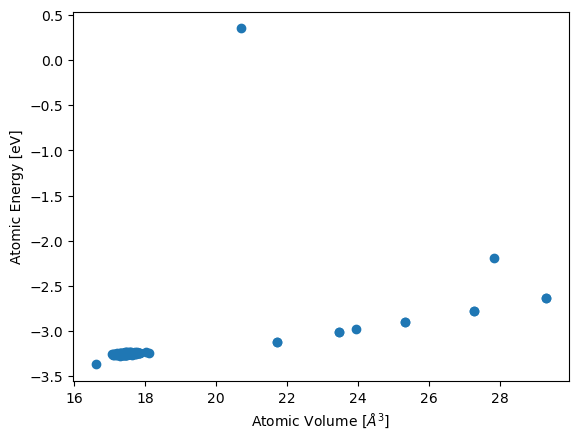

In [49]:
df = train.plot.energy_volume()

Text(0, 0.5, 'Energy [eV/atom]')

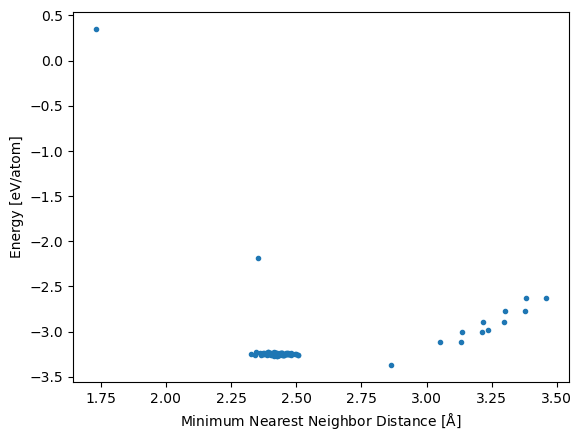

In [47]:
train.plot.energy_distance()
plt.xlabel(r'Minimum Nearest Neighbor Distance [$\mathrm{\AA}$]')
plt.ylabel('Energy [eV/atom]')

For fitting potentials within pyiron you can use the container as is, but if you have external tools, you can
export the data into a table.

In [48]:
train.to_pandas()

,name,atoms,energy,forces,stress,number_of_atoms
0,lammps_job,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 2.025000000000011, 2.025000000000011], index=1), Atom('Al', [2.0249999999995425, 1.239954884136415e-16, 2.025000000000011], index=2), Atom('...",-363.862004,"[[-1.94289029309402e-16, 2.39521527958808e-09, 2.39521426650957e-09], [7.216449660063519e-16, -1.2071273841618401e-10, -1.20712370654807e-10], [1.3045120539345601e-15, 2.3952162961360404e-09, -1.2...","[0.435159610868025, 0.42614374082336, 0.261845021537776, -0.017822346191073975, 0.06316340806208763, -0.04224910840534547]",108
1,lammps_job,"[Atom('Al', [12.26052483624332, 12.35079472361979, 12.228793859815706], index=0), Atom('Al', [12.27926359246061, 2.350685556290312, 1.9292011572446817], index=1), Atom('Al', [1.9926436773116334, 0...",-351.532120,"[[0.248583391837192, 0.23915877473413702, -0.23894105356543197], [-0.130888332852436, -0.914135461156863, 0.29880916380244094], [-0.33031991209593, -0.07401230961688571, 0.19996382362905699], [-0....","[-0.412756195663124, -0.15486702873221897, -0.08987491501087581, -0.378790613594144, 0.36708953824739105, 0.26290515386299895]",108
2,lammps_job,"[Atom('Al', [0.16673299411299752, 0.02735841974036502, 0.1614965038830852], index=0), Atom('Al', [12.466105041252858, 1.7918824186486473, 2.036731429861043], index=1), Atom('Al', [2.07445042718602...",-350.090052,"[[-0.407568938455615, -0.12454524565919002, -0.761693801796189], [0.0915818188080781, 1.06922899058779, 0.37054827119127604], [0.477218526094606, -0.07430501493642268, -0.281867421036727], [-0.014...","[-2.44893984296423, -2.72785595097851, -2.01897944784476, -0.18704350796992616, 0.20999230567067986, -0.024888389886959652]",108
3,lammps_job,"[Atom('Al', [12.21308348199425, 12.265988566177116, 12.19062815128558], index=0), Atom('Al', [0.21712250676166417, 2.1366865739950858, 2.1871135862802547], index=1), Atom('Al', [1.9835384713419646...",-350.023552,"[[-0.101787474583524, -0.138642013910513, 0.661173170619457], [-0.246540135754064, 0.11890385830203098, -0.09314630820128801], [0.234562836928222, 0.5130463855762, 0.54104975866972], [0.1148146548...","[1.1706011140504302, 1.40480623738935, 1.34209186398888, -0.006847759120169021, -0.356337551445931, -0.23811620096387093]",108
4,lammps_job,"[Atom('Al', [0.09617562787405216, 0.02902709615982282, 12.265207592429212], index=0), Atom('Al', [12.10450021001593, 2.1853144494770795, 2.1606069275310467], index=1), Atom('Al', [1.90223456545223...",-351.844544,"[[-0.372732845088115, 0.649671902915653, 0.580339996629424], [0.224308489446519, -0.458630108719773, -0.517812620726962], [0.0525606174145831, 0.721572798944994, -1.50976970862483], [-0.8221788352...","[1.24213434641981, 1.2813642265189302, 0.5605411478039011, -0.02452143363977044, 0.02793034059956806, -0.3022598010823979]",108
...,...,...,...,...,...,...
109,fcc_0d02500000000000001_rattle,"[Atom('Al', [2.4134567511705263, 2.381707828461447, 2.4210054704249027], index=0), Atom('Al', [2.4647725363401474, 4.765534418263802, 4.7655352391524275], index=1), Atom('Al', [0.07896064077517456...",-11.090023,"[[0.047653699364231805, 0.016994757564223306, -0.0665197797303496], [-0.0458101542675456, 0.014229520736453796, 0.005913001103890798], [-0.048016501434905795, -0.0664864319466422, 0.02556002386622...","[-10.4866510998641, -10.4911654721509, -10.4524149018046, 0.009473070312858144, -0.020000087715253804, -0.0190822495748971]",4
110,fcc_0d05_rattle,"[Atom('Al', [2.471715801012554, 2.439966878303366, 2.479264520266565], index=0), Atom('Al', [2.523031586182294, 4.882052517963707, 4.88205333885242], index=1), Atom('Al', [0.07896064077549242, 2.4...",-10.532061,"[[0.03516770778653589, 0.040279322363378195, -0.032850523654167595], [-0.036381031897443794, -0.0169568259853258, -0.014419645190428302], [-0.03540877891024069, -0.0219948896471505, 0.002351340644...","[-11.357783479012397, -11.364229685253997, -11.320916220266199, 0.007779670584864293, -0.031392581674793495, -0.011